# XGBoost trainer
This notebook function handles training and logging of xgboost models **only**, exposing both the sklearn and low level api"s.

## Steps
1. generate an xgboost model configuration by selecting one of 5 available types (currently, only classification implemented)
2. get a sample of data from a data source (random rows, consecutive rows, or the entire dataset, custom sample)
3. split the data into train, validation, and test sets (WIP, this will be parametrized cross-validator)  
4. train the model using xgboost in one of its flavours (dask, gpu, mpi...)
5. dump the model
6. evaluate the model

## Import Function

In [1]:
from mlrun import import_function
from mlrun.platforms.other import auto_mount

GPU = False


fn = import_function("hub://xgb_trainer")
fn.image = "mlrun/ml-models" if not GPU else "mlrun/ml-models-gpu"
fn.apply(auto_mount())

## Test Function

### Generate test data

In [2]:
from mlrun import import_function, mlconf, NewTask
from mlrun.platforms.other import auto_mount

gen_data = import_function("hub://gen_class_data").apply(auto_mount())

gen_params = {"n_samples"   : 10_000,
              "m_features"  : 5,
              "k_classes"   : 2,
              "weight"      : [0.5, 0.5],
              "sk_params"   : {"n_informative": 2},
              "file_ext"    : "csv"}


gen_data_run = gen_data.run(params=gen_params)

> 2021-08-01 13:12:07,833 [info] starting run gen-class-data-gen_class_data uid=1712de42861f4f19be29b7975c5507d0 DB=http://mlrun-api:8080
> 2021-08-01 13:12:07,904 [info] Job is running in the background, pod: gen-class-data-gen-class-data-rrcr2
> 2021-08-01 13:12:11,524 [info] run executed, status=completed
final state: completed


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
default,...5c5507d0,0,Aug 01 13:12:11,completed,gen-class-data-gen_class_data,kind=jobowner=jovyanhost=gen-class-data-gen-class-data-rrcr2,,"n_samples=10000m_features=5k_classes=2weight=[0.5, 0.5]sk_params={'n_informative': 2}file_ext=csv",,classifier-data


to track results use .show() or .logs() or in CLI: 
!mlrun get run 1712de42861f4f19be29b7975c5507d0 --project default , !mlrun logs 1712de42861f4f19be29b7975c5507d0 --project default
> 2021-08-01 13:12:14,008 [info] run executed, status=completed


### Setup XGBoost Parameters

In [3]:
task_params = { "model_type": "classifier",
        "CLASS_tree_method": "hist",
        "CLASS_objective": "binary:logistic",
        "CLASS_booster": "gbtree",
        "FIT_verbose": 0,
        "label_column": "labels"}

### run remotely

In [4]:
train_run = fn.run(params = task_params,    
    inputs={"dataset"  : gen_data_run.artifact('classifier-data')['target_path']})

> 2021-08-01 13:12:14,016 [info] starting run xgb-trainer-train_model uid=c434c010e8ff47b5aa96ee8211f12093 DB=http://mlrun-api:8080
> 2021-08-01 13:12:14,074 [info] Job is running in the background, pod: xgb-trainer-train-model-gq9rd
> 2021-08-01 13:12:19,020 [info] run executed, status=completed
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
final state: completed


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
default,...11f12093,0,Aug 01 13:12:17,completed,xgb-trainer-train_model,kind=jobowner=jovyanhost=xgb-trainer-train-model-gq9rd,dataset,model_type=classifierCLASS_tree_method=histCLASS_objective=binary:logisticCLASS_booster=gbtreeFIT_verbose=0label_column=labels,accuracy=0.9552test-error=0.0448rocauc=0.9799618829687036brier_score=0.038984999293145965f1-score=0.954983922829582precision_score=0.965679190751445recall_score=0.9445229681978798,test_setprobability-calibrationconfusion-matrixfeature-importancesprecision-recall-binaryroc-binarymodel


to track results use .show() or .logs() or in CLI: 
!mlrun get run c434c010e8ff47b5aa96ee8211f12093 --project default , !mlrun logs c434c010e8ff47b5aa96ee8211f12093 --project default
> 2021-08-01 13:12:20,169 [info] run executed, status=completed


### Display the probability calibration


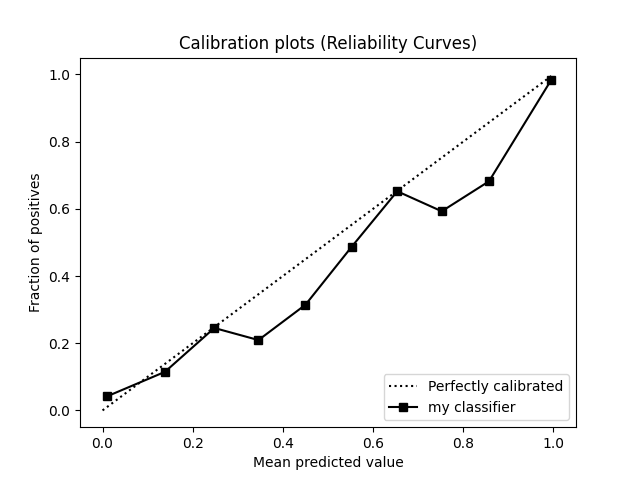

In [16]:
from IPython.display import HTML
HTML(train_run.artifact('probability-calibration')['target_path'])


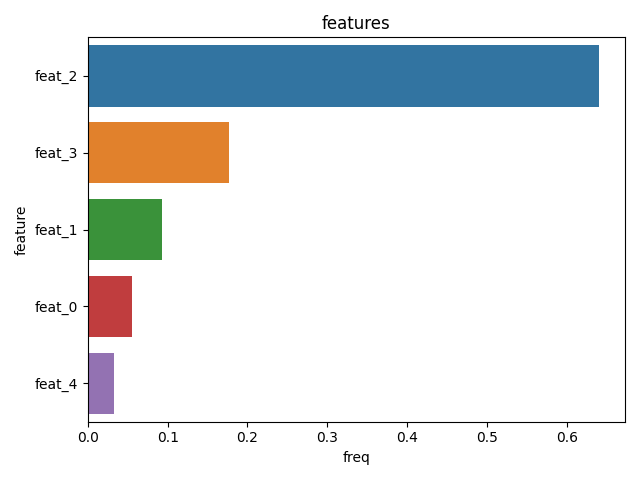

In [18]:
from IPython.display import HTML
HTML(train_run.artifact('feature-importances')['target_path'])
